In [1]:
import numpy as np    #基本矩陣計算工具
import pandas as pd   #基本資料視覺化工具
import matplotlib.pyplot as plt  #繪圖工具
import seaborn as sns
from datetime import datetime   #記錄時間
from scipy.stats import skew  #偏度計算
from scipy.special import boxcox1p  #box-cox變換工具
from scipy.stats import boxcox_normmax   
from sklearn.linear_model import LinearRegression, ElasticNetCV, LassoCV, RidgeCV  #線性模型
from sklearn.ensemble import GradientBoostingRegressor   #GBDT模型
from sklearn.svm import SVR  #SVR模型
from sklearn.pipeline import make_pipeline  #構建Pipeline 
from sklearn.preprocessing import RobustScaler  #穩健標準化，用於縮放包含許多異常值的資料
from sklearn.model_selection import KFold, RepeatedKFold, cross_val_score, GridSearchCV  #K折取樣以及交叉驗證
from sklearn.metrics import mean_squared_error   #均方根指標
from mlxtend.regressor import StackingCVRegressor   #帶交叉驗證的Stacking迴歸器
from xgboost import XGBRegressor    #XGBoost模型
from lightgbm import LGBMRegressor  #LGB模型
import warnings  #系統警告提示
import os   #系統讀取工具
warnings.filterwarnings('ignore')  #忽略警告

In [2]:
#檔案根目錄，輸入本地下載好的檔案目錄地址

DATA_ROOT = r'D:\dataset\kaggle\HPART'
print(os.listdir(DATA_ROOT))

['data_description.txt', 'sample_submission.csv', 'test.csv', 'train.csv']


In [3]:
#匯入訓練集、測試集和提交樣本
train = pd.read_csv(f'{DATA_ROOT}/train.csv')
test = pd.read_csv(f'{DATA_ROOT}/test.csv')
sub = pd.read_csv(f'{DATA_ROOT}/sample_submission.csv')
	
#列印資料維度
print("Train set size:", train.shape)
print("Test set size:", test.shape)

Train set size: (1460, 81)
Test set size: (1459, 80)


In [4]:
#先將樣本ID賦值並刪除
train_ID = train['Id']
test_ID = test['Id']

train.drop(['Id'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)

#整理出數值型特徵和類別型特徵
all_cols = test.columns.tolist()
numerical_cols = []
categorical_cols = []

for col in all_cols:
    if (test[col].dtype != 'object') :
        numerical_cols.append(col)
    else:
        categorical_cols.append(col)

print('數值型變數數目為：',len(numerical_cols))
print('類別型變數數目為：',len(categorical_cols))

數值型變數數目為： 36
類別型變數數目為： 43


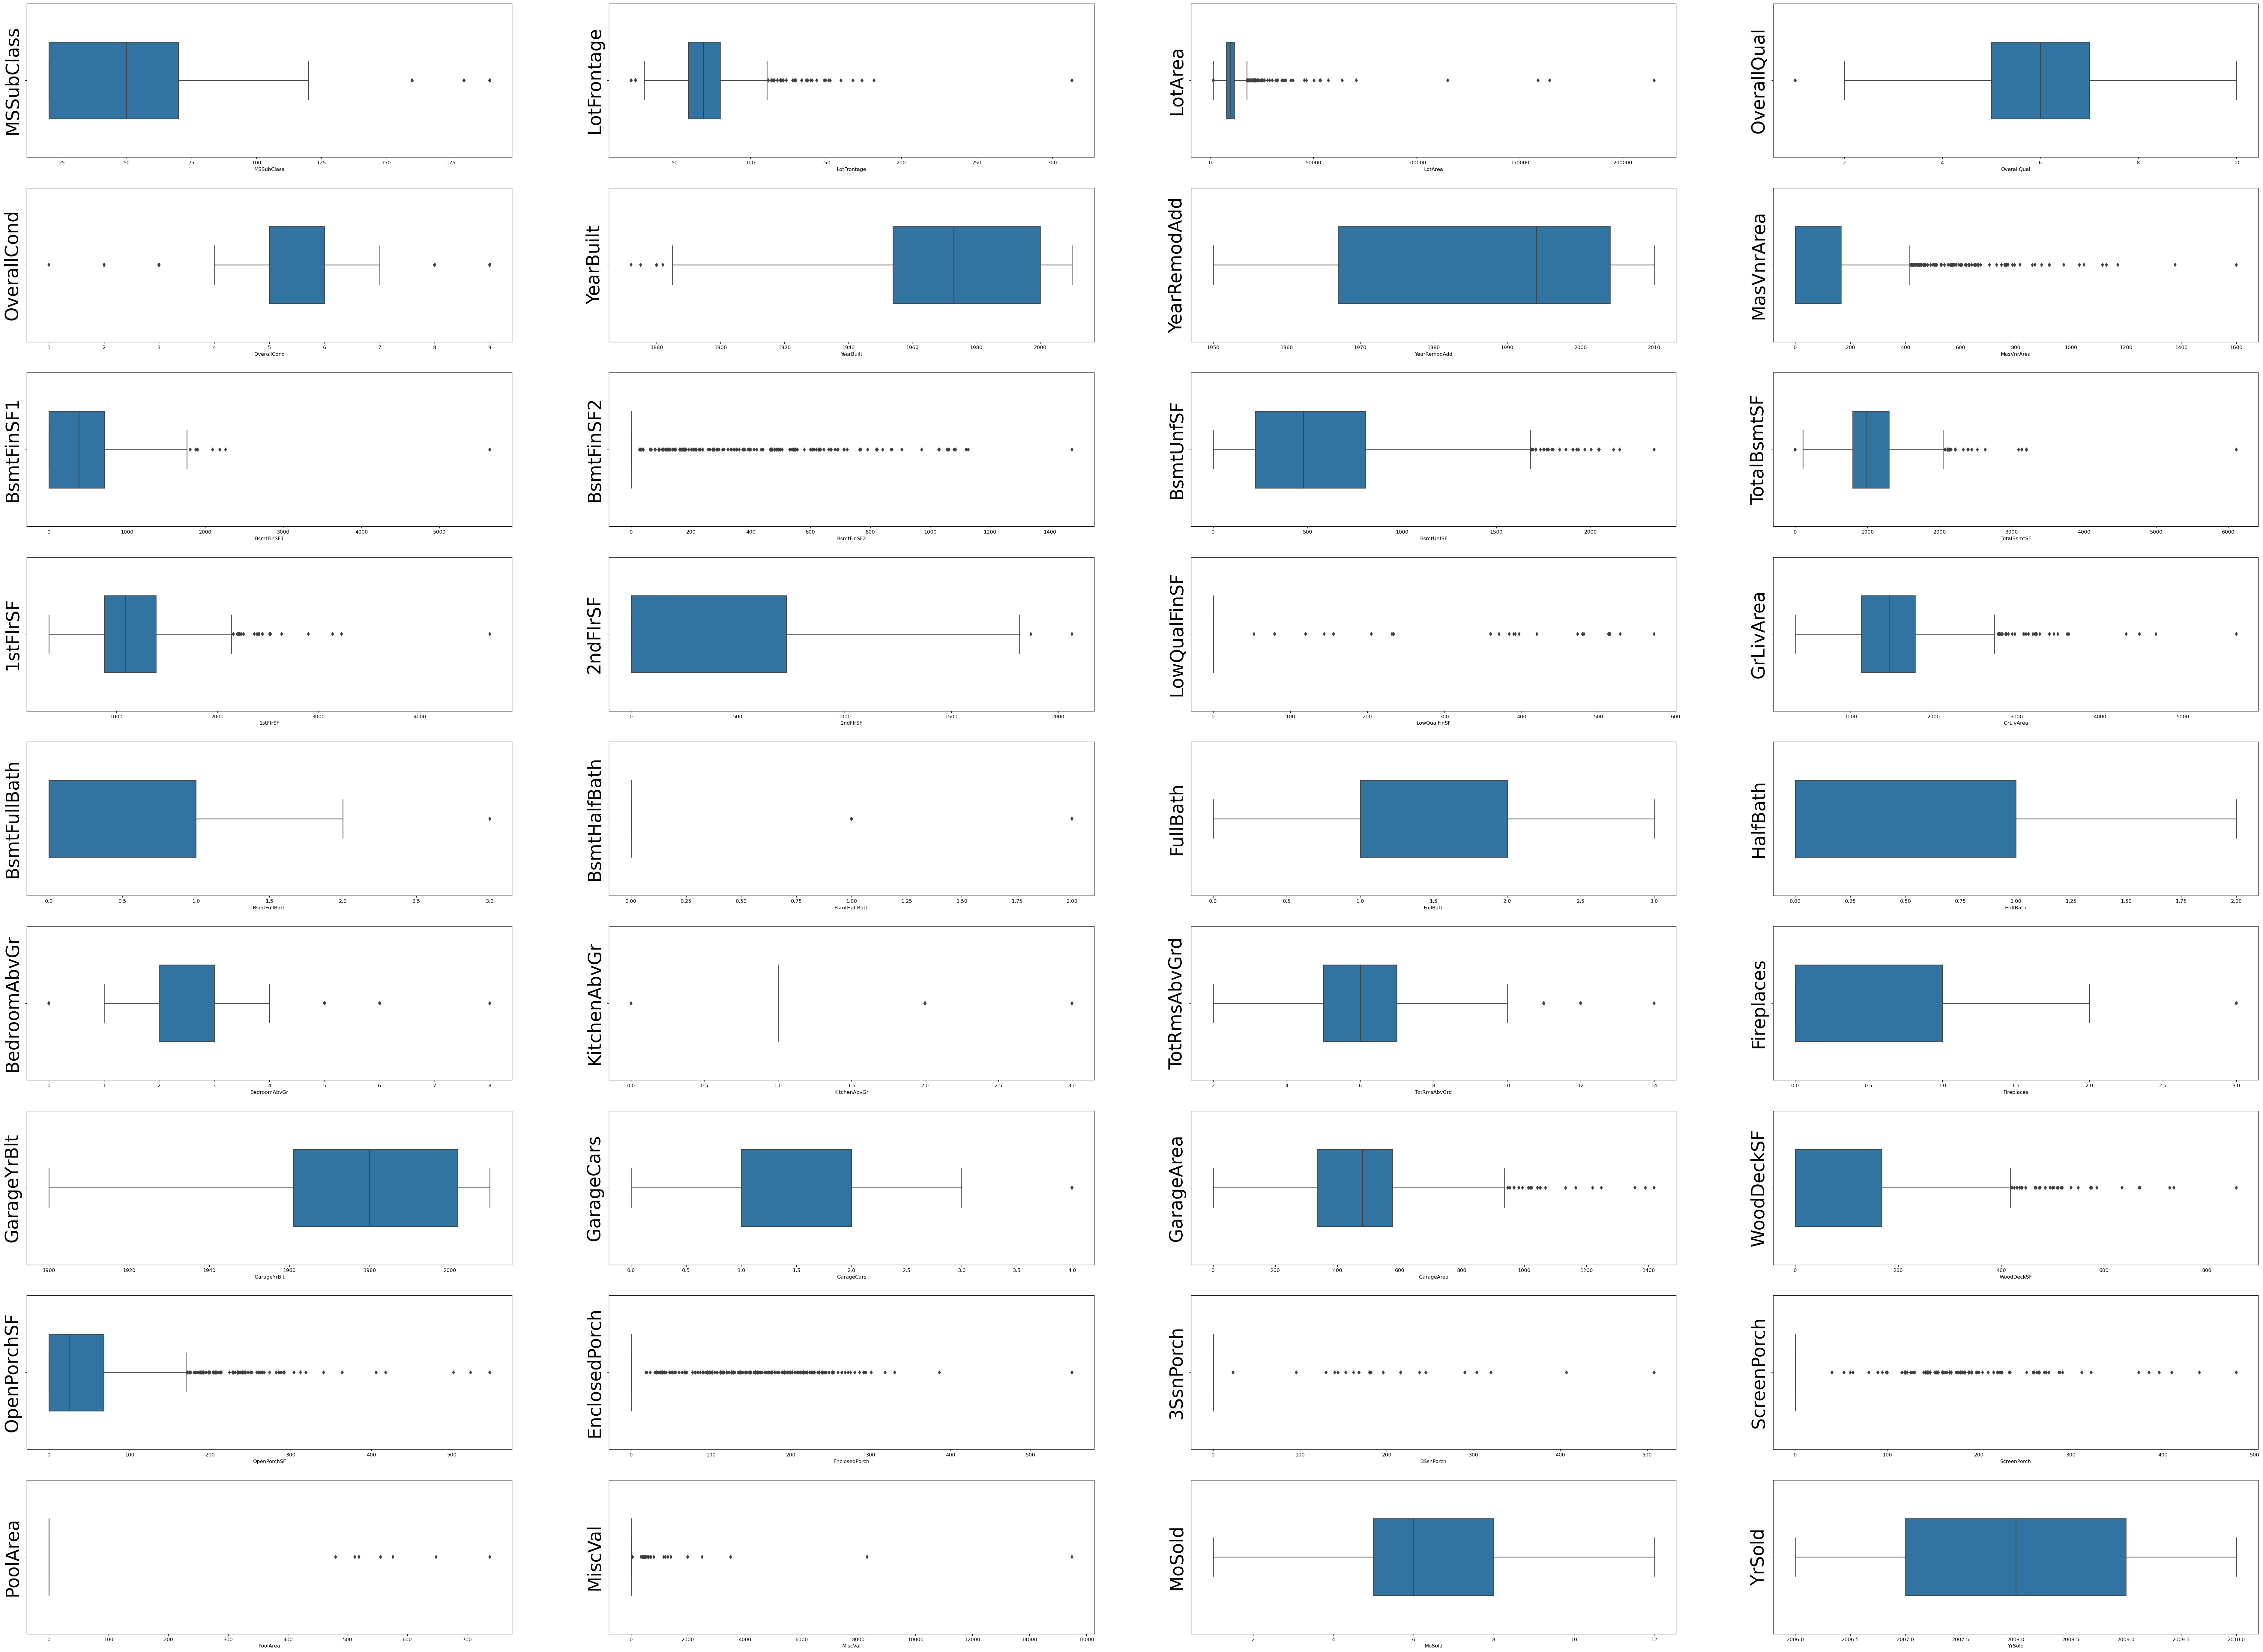

In [5]:
#對訓練集的連續性數值變數繪製箱型圖篩選異常值

fig = plt.figure(figsize=(80,60),dpi=120)
for i in range(len(numerical_cols)):
    plt.subplot(9, 4, i+1)
    sns.boxplot(train[numerical_cols[i]], orient='v', width=0.5)
    plt.ylabel(numerical_cols[i], fontsize=36)
plt.show()

<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

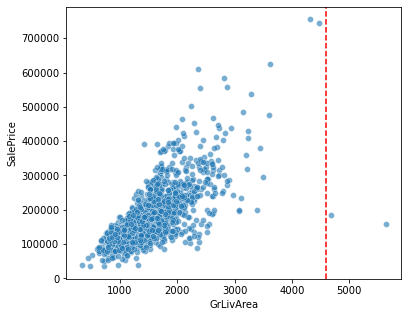

In [6]:
#地面上居住面積與房屋售價關係
fig = plt.figure(figsize=(6,5))
plt.axvline(x=4600, color='r', linestyle='--')
sns.scatterplot(x='GrLivArea',y='SalePrice',data=train, alpha=0.6)

In [7]:
train.GrLivArea.sort_values(ascending=False)[:4]

1298    5642
523     4676
1182    4476
691     4316
Name: GrLivArea, dtype: int64

<AxesSubplot:xlabel='LotArea', ylabel='SalePrice'>

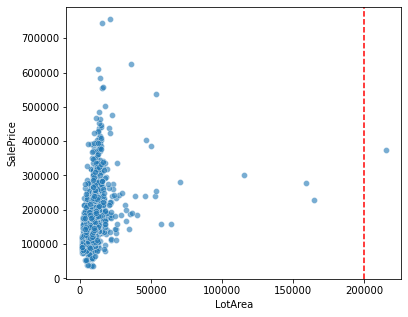

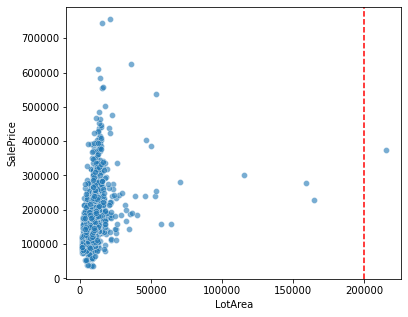

In [8]:
#地皮建築面積與房屋售價關係
fig = plt.figure(figsize=(6,5))
plt.axvline(x=200000, color='r', linestyle='--')
sns.scatterplot(x='LotArea',y='SalePrice',data=train, alpha=0.6)
# *強#地皮建築面積與房屋售價關係
fig = plt.figure(figsize=(6,5))
plt.axvline(x=200000, color='r', linestyle='--')
sns.scatterplot(x='LotArea',y='SalePrice',data=train, alpha=0.6)

<AxesSubplot:xlabel='TotalBsmtSF', ylabel='SalePrice'>

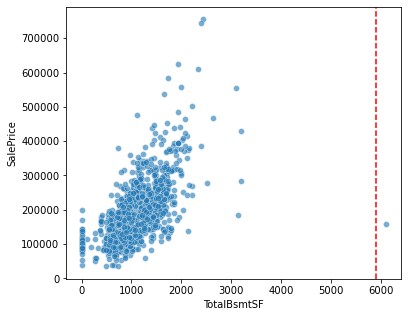

In [9]:
#地下室總面積與房屋售價關係
fig = plt.figure(figsize=(6,5))
plt.axvline(x=5900, color='r', linestyle='--')
sns.scatterplot(x='TotalBsmtSF',y='SalePrice',data=train, alpha=0.6)

<AxesSubplot:xlabel='1stFlrSF', ylabel='SalePrice'>

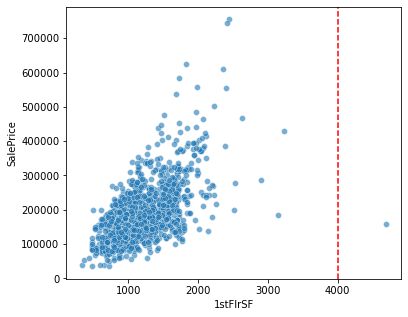

In [10]:
#第一層面積與房屋售價關係
fig = plt.figure(figsize=(6,5))
plt.axvline(x=4000, color='r', linestyle='--')
sns.scatterplot(x='1stFlrSF',y='SalePrice',data=train, alpha=0.6)

In [11]:
train['1stFlrSF'].sort_values(ascending=False)[:3]

1298    4692
496     3228
523     3138
Name: 1stFlrSF, dtype: int64

<AxesSubplot:xlabel='MasVnrArea', ylabel='SalePrice'>

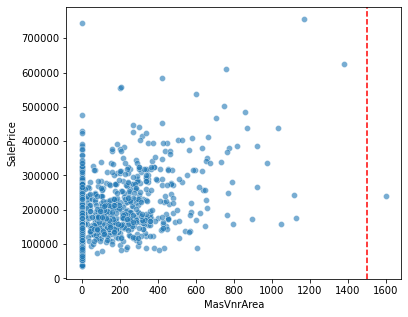

In [12]:
#裝飾石材面積與房屋售價關係
fig = plt.figure(figsize=(6,5))
plt.axvline(x=1500, color='r', linestyle='--')
sns.scatterplot(x='MasVnrArea',y='SalePrice',data=train, alpha=0.6)

In [13]:
#剔除異常值並將資料集重新排序
train = train[train.GrLivArea < 4600]
train = train[train.TotalBsmtSF < 5000]
train = train[train['1stFlrSF'] < 4000]
train.reset_index(drop=True, inplace=True)
train.shape

(1458, 80)

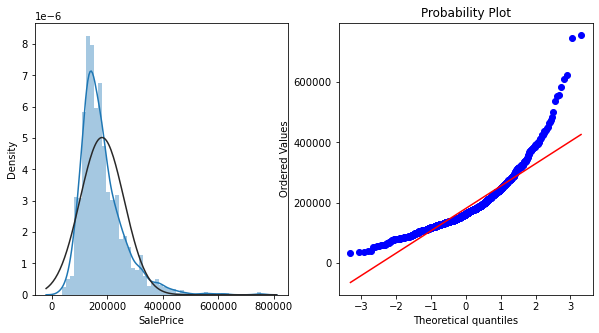

In [14]:
#對'SalePrice'繪製直方圖和Q-Q圖
from scipy import stats
plt.figure(figsize=(10,5))
ax_121 = plt.subplot(1,2,1)
sns.distplot(train["SalePrice"],fit=stats.norm)
ax_122 = plt.subplot(1,2,2)
res = stats.probplot(train["SalePrice"],plot=plt)

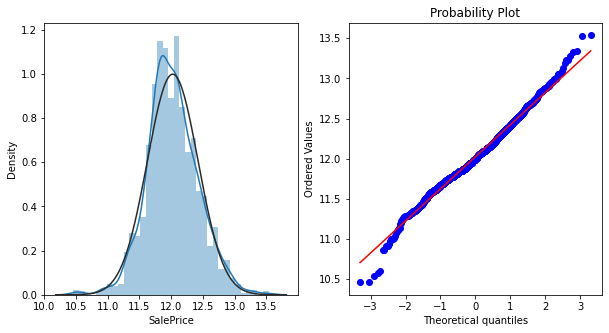

In [15]:
#使用log1p也就是log(1+x)，用來對房價資料進行資料預處理，它的好處是轉化後的資料更加服從正態分佈，有利於後續的評估結果。
#但需要注意最後需要將預測出的平滑資料還原，而還原過程就是log1p的逆運算expm1
train["SalePrice"] = np.log1p(train["SalePrice"])
plt.figure(figsize=(10,5))
ax_121 = plt.subplot(1,2,1)
sns.distplot(train["SalePrice"],fit=stats.norm)
ax_122 = plt.subplot(1,2,2)
res = stats.probplot(train["SalePrice"],plot=plt)

In [16]:
#分離標籤和特徵,合併訓練集和測試集便於統一預處理
y = train['SalePrice'].reset_index(drop=True)
train_features = train.drop(['SalePrice'], axis=1)
test_features= test.copy()
features = pd.concat([train_features, test_features],axis=0).reset_index(drop=True)
print("剔除訓練資料中的極端值後，將其特徵矩陣和測試資料中的特徵矩陣合併，維度為:",features.shape)

剔除訓練資料中的極端值後，將其特徵矩陣和測試資料中的特徵矩陣合併，維度為: (2917, 79)


In [17]:
#尋找數值變數中實際應該為類別變數的特徵（即並不連續分佈）
transform_cols = []
for col in numerical_cols:
    if len(features[col].unique()) < 20:
        transform_cols.append(col)
       
transform_cols

['MSSubClass',
 'OverallQual',
 'OverallCond',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageCars',
 'PoolArea',
 'MoSold',
 'YrSold']

In [18]:
#對於列名為'MSSubClass'、'YrSold'、'MoSold'的特徵列，將列中的資料型別轉化為string格式。
features['MSSubClass'] = features['MSSubClass'].apply(str)
features['YrSold'] = features['YrSold'].astype(str)
features['MoSold'] = features['MoSold'].astype(str)

#將其加入對應的組別
numerical_cols.remove('MSSubClass')
numerical_cols.remove('YrSold')
numerical_cols.remove('MoSold')
categorical_cols.append('MSSubClass')
categorical_cols.append('YrSold')
categorical_cols.append('MoSold')

In [19]:
#資料總缺失情況查閱
(features.isna().sum()/features.shape[0]).sort_values(ascending=False)[:35]

PoolQC          0.996915
MiscFeature     0.964004
Alley           0.932122
Fence           0.804251
FireplaceQu     0.486802
LotFrontage     0.166610
GarageYrBlt     0.054508
GarageFinish    0.054508
GarageQual      0.054508
GarageCond      0.054508
GarageType      0.053822
BsmtExposure    0.028111
BsmtCond        0.028111
BsmtQual        0.027768
BsmtFinType2    0.027425
BsmtFinType1    0.027083
MasVnrType      0.008228
MasVnrArea      0.007885
MSZoning        0.001371
Functional      0.000686
BsmtHalfBath    0.000686
BsmtFullBath    0.000686
Utilities       0.000686
SaleType        0.000343
BsmtFinSF1      0.000343
KitchenQual     0.000343
GarageCars      0.000343
BsmtUnfSF       0.000343
TotalBsmtSF     0.000343
Exterior2nd     0.000343
Exterior1st     0.000343
GarageArea      0.000343
Electrical      0.000343
BsmtFinSF2      0.000343
TotRmsAbvGrd    0.000000
dtype: float64

In [20]:
#PoolQC, NA表示沒有游泳池，為一個型別
print(features["PoolQC"].unique())
print(features["PoolQC"].fillna("None").unique())   #空值填充為str型資料"None",表示沒有泳池。

[nan 'Ex' 'Fa' 'Gd']
['None' 'Ex' 'Fa' 'Gd']


In [21]:
#MiscFeature， NA表示-其他類別中「沒有」未涵蓋的其他特性，故填充為"None"
print(features["MiscFeature"].unique())
print(features["MiscFeature"].fillna("None").unique())

[nan 'Shed' 'Gar2' 'Othr' 'TenC']
['None' 'Shed' 'Gar2' 'Othr' 'TenC']


In [22]:
#由於類別型變數的許多NA均表示沒有此功能，先從data_distribution中找出這樣的列然後統一填充為"None"
(features[categorical_cols].isna().sum()/features.shape[0]).sort_values(ascending=False)[:25]

PoolQC          0.996915
MiscFeature     0.964004
Alley           0.932122
Fence           0.804251
FireplaceQu     0.486802
GarageCond      0.054508
GarageQual      0.054508
GarageFinish    0.054508
GarageType      0.053822
BsmtExposure    0.028111
BsmtCond        0.028111
BsmtQual        0.027768
BsmtFinType2    0.027425
BsmtFinType1    0.027083
MasVnrType      0.008228
MSZoning        0.001371
Functional      0.000686
Utilities       0.000686
Electrical      0.000343
SaleType        0.000343
Exterior1st     0.000343
KitchenQual     0.000343
Exterior2nd     0.000343
Street          0.000000
LandSlope       0.000000
dtype: float64

In [23]:
for col in ('PoolQC', 'MiscFeature','Alley', 'Fence', 'FireplaceQu', 'MasVnrType', 'Utilities',
            'GarageCond', 'GarageQual', 'GarageFinish', 'GarageType', 
            'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    features[col] = features[col].fillna('None')
    
(features[categorical_cols].isna().sum()/features.shape[0]).sort_values(ascending=False)[:10]

MSZoning       0.001371
Functional     0.000686
SaleType       0.000343
Electrical     0.000343
KitchenQual    0.000343
Exterior2nd    0.000343
Exterior1st    0.000343
GarageType     0.000000
Heating        0.000000
HeatingQC      0.000000
dtype: float64

In [24]:
#其餘類別型變數由所在列的眾數填充
for col in ('Functional', 'SaleType', 'Electrical', 'Exterior2nd', 'Exterior1st', 'KitchenQual'):
    features[col] = features[col].fillna(features[col].mode()[0])

(features[categorical_cols].isna().sum()/features.shape[0]).sort_values(ascending=False)[:3]

MSZoning        0.001371
GarageFinish    0.000000
BsmtFinType2    0.000000
dtype: float64

In [25]:
#由於MSSubClass（確定銷售涉及的住宅型別）和 MSZoning（銷售分割區的一般分類確定）之間有一定聯絡。
#具體來說是指在MSSubClass基礎上確定MSZoning，故可以按照'MSSubClass'列中的元素分佈進行分組，然後將'MSZoning'列分組後取眾數填充。
features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
print('類別型資料缺失值數量為：', features[categorical_cols].isna().sum().sum())

類別型資料缺失值數量為： 0


In [26]:
#數值型變數缺失情況
(features[numerical_cols].isna().sum()/features.shape[0]).sort_values(ascending=False)[:12]

LotFrontage     0.166610
GarageYrBlt     0.054508
MasVnrArea      0.007885
BsmtFullBath    0.000686
BsmtHalfBath    0.000686
BsmtFinSF1      0.000343
BsmtFinSF2      0.000343
BsmtUnfSF       0.000343
TotalBsmtSF     0.000343
GarageArea      0.000343
GarageCars      0.000343
YearRemodAdd    0.000000
dtype: float64

In [27]:
#因為某些類別型變數為"None"，表示不包含此項，所以造成數值型變數也會缺失，故將這樣的數值變數缺失值填充為"0"
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars', 'MasVnrArea',
            'BsmtHalfBath', 'BsmtFullBath', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF'):
    features[col] = features[col].fillna(0)
    
(features[numerical_cols].isna().sum()/features.shape[0]).sort_values(ascending=False)[:3]

LotFrontage    0.16661
FullBath       0.00000
PoolArea       0.00000
dtype: float64

In [28]:
#對於 LotFrontage （連線到地產的街道的直線英尺距離）而言，其受Neighborhood（城市限制內的物理位置）的影響
#故對於這兩個特徵進行分組後取列的中位數填充
features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
print('數值型資料缺失值數量為：',features[numerical_cols].isna().sum().sum())

數值型資料缺失值數量為： 0


In [29]:
#GrLivArea： 地上居住總面積
#TotalBsmtSF： 地下室總面積
#將二者加和形成新的「總居住面積」特徵
features['TotalSF'] = features['GrLivArea'] + features['TotalBsmtSF']

#LotArea： 建築面積
#LotFrontage: 房子同街道之間的距離
#將二者乘積形成新的「區域面積」特徵
features['Area'] = features['LotArea'] * features['LotFrontage']

#OpenPorchSF ：開放式門廊面積
#EnclosedPorch ：封閉式門廊面積
#3SsnPorch ：時令門廊面積
#ScreenPorch ：屏風門廊面積
#將四者加和形成新的"門廊總面積"特徵
features['Total_porch_sf'] = (features['OpenPorchSF'] + features['EnclosedPorch'] + 
                              features['3SsnPorch'] + features['ScreenPorch'])
                              
#FullBath ：地面上的全浴室數目
#HalfBath ：地面以上半浴室數目
#BsmtFullBath ：地下室全浴室數量
#BsmtHalfBath ：地下室半浴室數量
#將半浴室權重設為0.5，全浴室為1，將四者加和形成新的"總浴室數目"特徵
features['Total_Bathrooms'] = (features['FullBath'] + (0.5 * features['HalfBath']) +
                               features['BsmtFullBath'] + (0.5 * features['BsmtHalfBath']))

#將新特徵加入到數值變數中
numerical_cols.append('TotalSF')
numerical_cols.append('Area')
numerical_cols.append('Total_porch_sf')
numerical_cols.append('Total_Bathrooms')
print('特徵建立後的資料維度 :', features.shape)

特徵建立後的資料維度 : (2917, 83)


<AxesSubplot:>

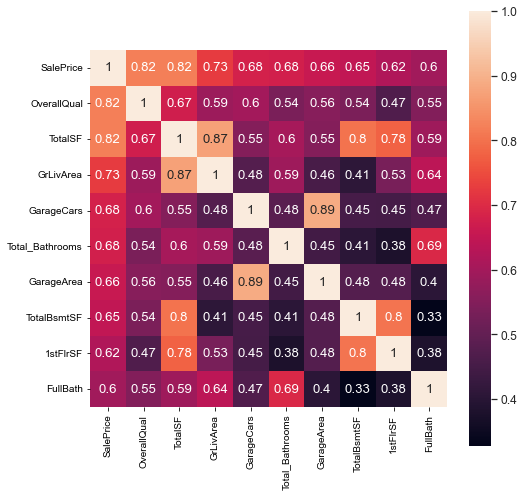

In [30]:
#檢視與標籤10個最相關的特徵屬性
train_ = features.iloc[:len(y),:]
train_ = pd.concat([train_,y],axis=1)
cols = train_ .corr().nlargest(10, 'SalePrice').index

plt.subplots(figsize=(8,8))
sns.set(font_scale=1.1)
sns.heatmap(train_ [cols].corr(),square=True, annot=True)

<AxesSubplot:xlabel='OverallQual'>

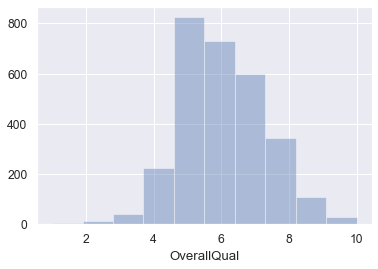

In [31]:
#完工品質和材料
sns.distplot(features['OverallQual'],bins=10,kde=False)

In [32]:
#完工品質和材料分組
def OverallQual_category(cat):
    if cat <= 4:
        return 1
    elif cat <= 6 and cat > 4:
        return 2
    else:
        return 3

features['OverallQual_cat'] = features['OverallQual'].apply(OverallQual_category)

<AxesSubplot:xlabel='TotalSF'>

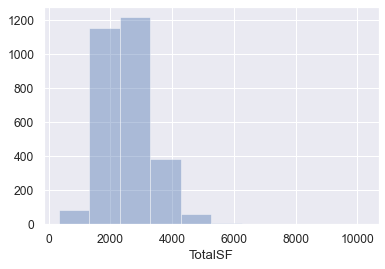

In [33]:
#總居住面積
sns.distplot(features['TotalSF'],bins=10,kde=False)

In [34]:
#總居住面積分組
def TotalSF_category(cat):
    if cat <= 2000:
        return 1
    elif cat <= 3000 and cat > 2000:
        return 2
    elif cat <= 4000 and cat > 3000:
        return 3
    else:
        return 4

features['TotalSF_cat'] = features['TotalSF'].apply(TotalSF_category)

In [35]:
#然後將建立的分組加入類別型變數中
categorical_cols.append('GarageArea')  
categorical_cols.append('GrLivArea')   
categorical_cols.append('TotalBsmtSF') 
categorical_cols.append('TotalSF_cat') 
categorical_cols.append('OverallQual')   
categorical_cols.append('LotFrontage')  
categorical_cols.append('YearBuilt')    
categorical_cols.append('YearRemodAdd') 
categorical_cols.append('GarageYrBlt') 

#列印當前資料維度
features.shape

(2917, 85)

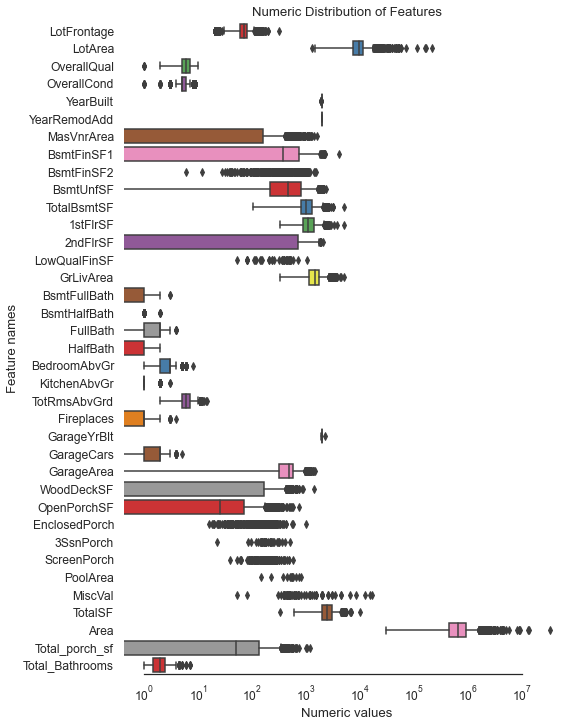

In [36]:
#檢視數值型特徵變數的偏度情況並繪圖
skew_features = features[numerical_cols].apply(lambda x: skew(x)).sort_values(ascending=False)

sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 12))
ax.set_xscale("log")
ax = sns.boxplot(data=features[numerical_cols], orient="h", palette="Set1")
ax.xaxis.grid(False)
ax.set(ylabel="Feature names")
ax.set(xlabel="Numeric values")
ax.set(title="Numeric Distribution of Features")
sns.despine(trim=True, left=True)

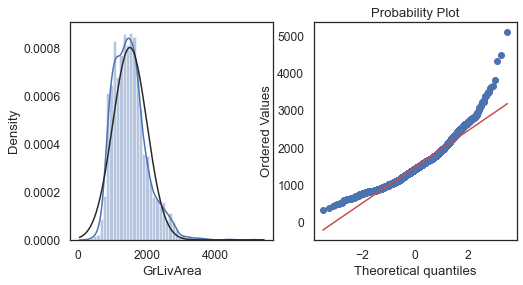

In [37]:
#對特徵變數'GrLivArea',繪製直方圖和Q-Q圖,以清楚資料分佈結構
plt.figure(figsize=(8,4))
ax_121 = plt.subplot(1,2,1)
sns.distplot(features['GrLivArea'],fit=stats.norm)
ax_122 = plt.subplot(1,2,2)
res = stats.probplot(features['GrLivArea'],plot=plt)

In [38]:
#以0.5作為閾值，統計偏度超過此數值的高偏度分佈資料列，獲取這些資料列的index
high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index
print("There are {} numerical features with Skew > 0.5 :".format(high_skew.shape[0]))
high_skew.sort_values(ascending=False)

There are 28 numerical features with Skew > 0.5 :


MiscVal           21.939672
Area              18.642721
PoolArea          17.688664
LotArea           13.109495
LowQualFinSF      12.084539
3SsnPorch         11.372080
KitchenAbvGr       4.300550
BsmtFinSF2         4.144503
EnclosedPorch      4.002344
ScreenPorch        3.945101
BsmtHalfBath       3.929996
MasVnrArea         2.621719
OpenPorchSF        2.529358
Total_porch_sf     2.244500
WoodDeckSF         1.844792
1stFlrSF           1.257286
LotFrontage        1.103039
GrLivArea          1.068750
TotalSF            1.011805
BsmtFinSF1         0.980645
BsmtUnfSF          0.919688
2ndFlrSF           0.861556
TotRmsAbvGrd       0.749232
Fireplaces         0.725278
HalfBath           0.696666
TotalBsmtSF        0.671751
BsmtFullBath       0.622415
OverallCond        0.569314
dtype: float64

In [39]:
#使用boxcox_normmax用於找出最佳的λ值
for i in skew_index:
    features[i] = boxcox1p(features[i], boxcox_normmax(features[i] + 1))

features[numerical_cols].apply(lambda x: skew(x)).sort_values(ascending=False)

PoolArea           15.595057
3SsnPorch           8.862045
LowQualFinSF        8.492615
MiscVal             5.237983
BsmtHalfBath        3.779434
KitchenAbvGr        3.778336
ScreenPorch         3.152631
BsmtFinSF2          2.578329
EnclosedPorch       2.149132
MasVnrArea          0.977618
2ndFlrSF            0.895453
WoodDeckSF          0.785550
HalfBath            0.732625
OpenPorchSF         0.621231
BsmtFullBath        0.616643
Fireplaces          0.553135
Total_Bathrooms     0.486443
OverallCond         0.382457
BsmtFinSF1          0.365986
Total_porch_sf      0.355994
BedroomAbvGr        0.326568
TotalBsmtSF         0.297009
GarageArea          0.216857
OverallQual         0.189591
FullBath            0.165514
LotFrontage         0.059189
BsmtUnfSF           0.054195
TotRmsAbvGrd        0.047190
TotalSF             0.027351
GrLivArea           0.008823
Area                0.000000
1stFlrSF           -0.007822
LotArea            -0.138117
GarageCars         -0.219297
YearRemodAdd  

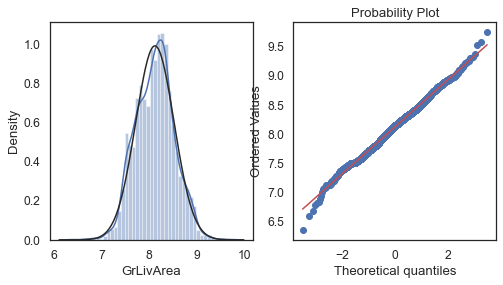

In [40]:
#box-cox變換後的對特徵變數'GrLivArea'
plt.figure(figsize=(8,4))
ax_121 = plt.subplot(1,2,1)
sns.distplot(features['GrLivArea'],fit=stats.norm)
ax_122 = plt.subplot(1,2,2)
res = stats.probplot(features['GrLivArea'],plot=plt)


In [41]:
#對於類別型特徵變數中，單個型別佔比超過99％以上的特徵（即＞ 2888個）進行刪除.
freq_ = features[categorical_cols].describe(include='O').T.freq
drop_cols = []
for index,num in enumerate(freq_):
    if (freq_[index] > 2888) :
        drop_cols.append(freq_.index[index])

features = features.drop(drop_cols, axis=1)
print('These drop_cols are:', drop_cols)
print('The new shape is :', features.shape)

categorical_cols.remove('Street')
categorical_cols.remove('PoolQC')
categorical_cols.remove('Utilities')

These drop_cols are: ['Street', 'Utilities', 'PoolQC']
The new shape is : (2917, 82)


In [43]:
#通過對於特徵含義理解，篩選出了以下幾個變數進行二值化處理
features['HasPool'] = features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
features['HasWoodDeckSF'] = features['WoodDeckSF'].apply(lambda x: 1 if x > 0 else 0)
features['Hasfireplace'] = features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
features['HasBsmt'] = features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
features['HasGarage'] = features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)

#檢視當前特徵數
print("經過特徵處理後的特徵維度為 :",features.shape)

經過特徵處理後的特徵維度為 : (2917, 87)


In [44]:
#使用pd.get_dummies()方法對特徵矩陣進行類似「座標投影」操作，獲得在新空間下onehot的特徵表達。
final_features = pd.get_dummies(features,columns=categorical_cols).reset_index(drop=True)
print("經過onehot編碼後的特徵維度為 :", final_features.shape)

經過onehot編碼後的特徵維度為 : (2917, 3701)


In [46]:
#訓練集&測試集資料還原
X_train = final_features.iloc[:len(y), :]
X_sub = final_features.iloc[len(y):, :]
print("訓練集特徵維度為：", X_train.shape)
print("測試集特徵維度為：", X_sub.shape)

訓練集特徵維度為： (1458, 3701)
測試集特徵維度為： (1459, 3701)


In [47]:
#定義迴歸模型找出異常值並繪圖的函數
def find_outliers(model, X, y, sigma=4):
    try:
        y_pred = pd.Series(model.predict(X), index=y.index)
    except:
        model.fit(X,y)
        y_pred = pd.Series(model.predict(X), index=y.index)
    
    #計算模型預測y值與真實y值之間的殘差
    resid = y - y_pred
    mean_resid = resid.mean()
    std_resid = resid.std()
    
    #計算異常值定義的引數z引數,資料的|z|大於σ將會被視為異常
    z = (resid - mean_resid) / std_resid
    outliers = z[abs(z) > sigma].index
    
    #列印結果並繪製影象
    print('R2 = ',model.score(X,y))
    print('MSE = ',mean_squared_error(y, y_pred))
    print('RMSE = ',np.sqrt(mean_squared_error(y, y_pred)))
    print('------------------------------------------')
    
    print('mean of residuals',mean_resid)
    print('std of residuals',std_resid)
    print('------------------------------------------')
    
    print(f'find {len(outliers)}','outliers：')
    print(outliers.tolist())
    
    plt.figure(figsize=(15,5))
    ax_131 = plt.subplot(1,3,1)
    plt.plot(y,y_pred,'.')
    plt.plot(y.loc[outliers],y_pred.loc[outliers],'ro')
    plt.legend(['Accepted','Outliers'])
    plt.xlabel('y')
    plt.ylabel('y_pred');
    
    ax_132 = plt.subplot(1,3,2)
    plt.plot(y, y-y_pred, '.')
    plt.plot(y.loc[outliers],y.loc[outliers] - y_pred.loc[outliers],'ro')
    plt.legend(['Accepted','Outliers'])
    plt.xlabel('y')
    plt.ylabel('y - y_pred');
    
    ax_133 = plt.subplot(1,3,3)
    z.plot.hist(bins=50, ax=ax_133)
    z.loc[outliers].plot.hist(color='r', bins=30, ax=ax_133)
    plt.legend(['Accepted','Outliers'])
    plt.xlabel('z')
    
    return outliers

R2 =  1.0
MSE =  2.474944934774543e-26
RMSE =  1.5731957712804033e-13
------------------------------------------
mean of residuals -5.397298215736015e-16
std of residuals 1.573726291992934e-13
------------------------------------------
find 1 outliers：
[304]


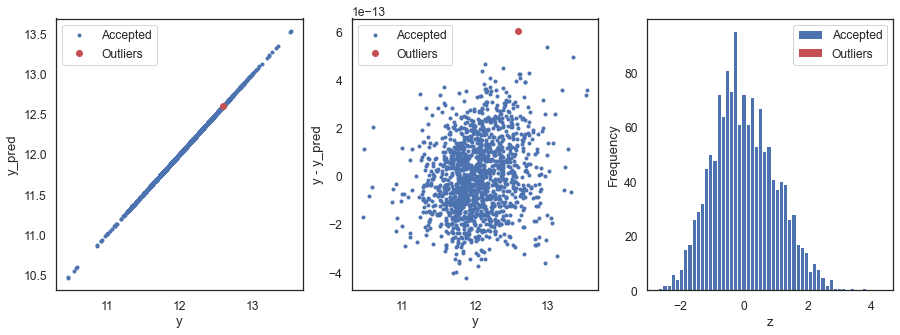

In [48]:
#使用LR迴歸模型
outliers_lr = find_outliers(LinearRegression(), X_train, y, sigma=3.5)

R2 =  0.7306240710197571
MSE =  0.0430087662734897
RMSE =  0.20738554981842322
------------------------------------------
mean of residuals -8.95488530150332e-16
std of residuals 0.2074567062966943
------------------------------------------
find 7 outliers：
[30, 410, 495, 631, 687, 915, 967]


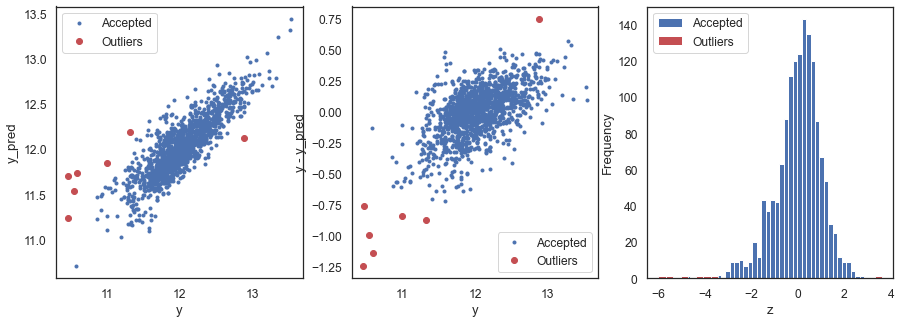

In [49]:
#使用Elasnet模型
outliers_ent = find_outliers(ElasticNetCV(), X_train, y, sigma=3.5)

R2 =  0.9938846637915312
MSE =  0.0009763792431993221
RMSE =  0.03124706775362005
------------------------------------------
mean of residuals -2.0524431609318976e-05
std of residuals 0.031257782255678705
------------------------------------------
find 0 outliers：
[]


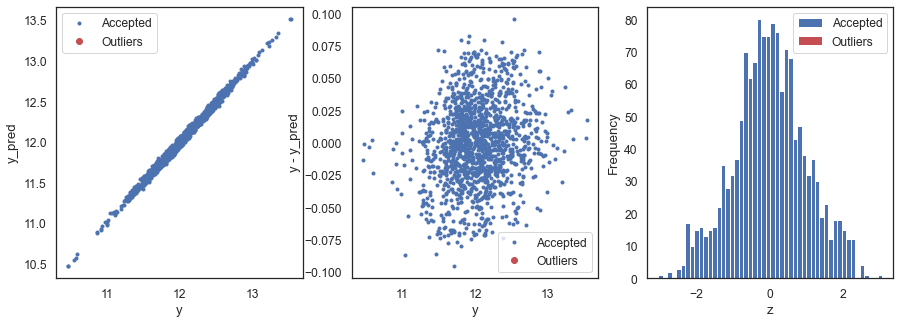

In [50]:
#使用XGB模型
outliers_xgb = find_outliers(XGBRegressor(), X_train, y, sigma=4)

In [51]:
outliers = [30, 462, 631, 967]
X_train = X_train.drop(X_train.index[outliers])
y = y.drop(y.index[outliers])

In [52]:
overfit = []
for i in X_train.columns:
    counts = X_train[i].value_counts(ascending=False)
    zeros = counts.iloc[0]
    if zeros / len(X_train) * 100 > 99.95:
        overfit.append(i)
        
overfit

['Area',
 'MSSubClass_150',
 'GarageArea_100.0',
 'GarageArea_162.0',
 'GarageArea_184.0',
 'GarageArea_185.0',
 'GarageArea_195.0',
 'GarageArea_207.0',
 'GarageArea_209.0',
 'GarageArea_215.0',
 'GarageArea_217.0',
 'GarageArea_224.0',
 'GarageArea_226.0',
 'GarageArea_231.0',
 'GarageArea_242.0',
 'GarageArea_249.0',
 'GarageArea_253.0',
 'GarageArea_257.0',
 'GarageArea_258.0',
 'GarageArea_263.0',
 'GarageArea_265.0',
 'GarageArea_266.0',
 'GarageArea_267.0',
 'GarageArea_272.0',
 'GarageArea_293.0',
 'GarageArea_295.0',
 'GarageArea_307.0',
 'GarageArea_310.0',
 'GarageArea_311.0',
 'GarageArea_313.0',
 'GarageArea_316.0',
 'GarageArea_317.0',
 'GarageArea_323.0',
 'GarageArea_331.0',
 'GarageArea_332.0',
 'GarageArea_340.0',
 'GarageArea_344.0',
 'GarageArea_345.0',
 'GarageArea_351.0',
 'GarageArea_353.0',
 'GarageArea_355.0',
 'GarageArea_356.0',
 'GarageArea_357.0',
 'GarageArea_363.0',
 'GarageArea_365.0',
 'GarageArea_369.0',
 'GarageArea_371.0',
 'GarageArea_374.0',
 'Gara

In [53]:
#對訓練集和測試集同時刪除這些列
X_train = X_train.drop(overfit, axis=1).copy()
X_sub = X_sub.drop(overfit, axis=1).copy()
print('經過異常值和過擬合刪除後訓練集的特徵維度為：', X_train.shape)
print('經過異常值和過擬合刪除後測試集的特徵維度為：', X_sub.shape)

經過異常值和過擬合刪除後訓練集的特徵維度為： (1454, 2737)
經過異常值和過擬合刪除後測試集的特徵維度為： (1459, 2737)
